In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools

In [0]:
num_players = 3
num_stimuli = 8


num_iterations = 80
epsilon = .001
inhibition = .05
delta = .001
beta = .15
MU = .2

log2 = lambda x: math.log(x)/math.log(2)
# response[a][b] is the probability neuron a (where a=0 means x) outputs 1
# when the b stimulus happens (32 values)



In [0]:
#conditional_probability[j][k][x][y] is P(node x = j | node y = k)
def generate_conditional_probabilities():
  #j = 1, k = 1
  result11 = np.matmul(stimuli_probability*response, response.T) /(np.dot(response,stimuli_probability))
    #j = 1, k = 0
  result10 = np.matmul(stimuli_probability*response, (1-response.T)) /(np.dot(1-response,stimuli_probability))
  result01 = np.matmul(stimuli_probability*(1-response), response.T) /(np.dot(response,stimuli_probability))
  result00 = np.matmul(stimuli_probability*(1-response), (1-response.T))/(np.dot(1-response,stimuli_probability))
  
  conditional_probability =  np.array([[result00,result01],[ result10,result11]])


  return conditional_probability

In [0]:
#returns updated "response" matrix
def update_response(EV, jitter):
  new_responses = np.zeros(shape = ((num_players,num_stimuli)))
  
  for node in range(num_players):
    for stimuli in range(num_stimuli):

      numerator = response[node][stimuli]*math.exp(beta*(EV[node][stimuli][1]-EV[node][stimuli][0]))
      denominator = 1-response[node][stimuli] + response[node][stimuli]*math.exp(beta*(EV[node][stimuli][1]-EV[node][stimuli][0]))
      term = jitter + numerator/denominator
      
      new_responses[node][stimuli] = max(epsilon,min(1-epsilon,term))

  return new_responses


In [0]:
def get_mutual_information():


  binary_options = list(itertools.product([0, 1], repeat=num_players))
  responses_both = [response,1-response]
  
  total_sum = 0
  for stimuli in range(num_stimuli):
    for options in binary_options:
      Pxy = Pr(responses_both, options, stimuli)*stimuli_probability[stimuli]
      Px = stimuli_probability[stimuli]
      Py = 0
      for stimuli_inner in range(num_stimuli):
        Py += stimuli_probability[stimuli_inner]*Pr(responses_both, options, stimuli_inner)
      total_sum += Pxy*math.log(Pxy/(Px*Py))
  return total_sum

#example: probability that the 4 nodes output [0,1,0,1] given the stimuli of index "stimuli=6"
def Pr(responses_both, options, stimuli):
  sums = 1
  for player in range(num_players):
    sums *= responses_both[options[player]][player][stimuli]
  return sums
# get_mutual_information()

## display bar graph of responses

In [0]:
#@title
def show_graph():


  # data to plot

  

  # create plot
  fig, ax = plt.subplots()
  index = np.arange(num_stimuli)
  bar_width = 0.1
  opacity = 0.8
  
  colors = ['r','g','b','c','m','k','r','g','b','c','m','k']
  for i in range(len(response)):
    rects0 = plt.bar(index+bar_width*i, response[i], bar_width,
                     color=colors[i],
                     label='player {}'.format(i))


  plt.xlabel('Stimuli')
  plt.ylabel('Responsiveness')
  plt.ylim(0,1)
  plt.title('Responsiveness to stimuli by node')
  plt.xticks(index + bar_width, ('Stim 1', '2', '3', '4','5','6','7','8'))
  plt.legend()
 

  
  plt.show()

In [0]:
# EV_values[x][b][c] is EV(Node x = c | S_b) 
def generate_BTS(conditional_probabilities):
  EV_values = np.zeros(shape = (num_players,num_stimuli,2))
  responses_both = [1-response,response]
  for node in range(num_players):
    for stimuli in range(num_stimuli):
      for output in range(2):
        EV = log2(responses_both[output][node][stimuli])
        EV -= np.dot(responses_both[output][node],stimuli_probability) #Pr(x=1)
        
        for node2 in range(num_players):
          if node2 == node:
            continue
          for output2 in range(2):
            EV+= 1/3*responses_both[output2][node2][stimuli]*log2(np.dot(responses_both[output2][node2],stimuli_probability))
        EV_values[node][stimuli][output] = EV
           
  return EV_values

# EV_values[x][b][c] is EV(Node x = c | S_b) 
def generate_BTS2(conditional_probabilities):
  EV_values = np.zeros(shape = (num_players,num_stimuli,2))
  responses_both = [1-response, response]
  for node in range(num_players):
    for stimuli in range(num_stimuli):
      for output in range(2):
        EV = log2(responses_both[output][node][stimuli])
        
        for node2 in range(num_players):
          if node2 == node:
            continue
          for output2 in range(2):
#             print()
#             print(conditional_probabilities[output2][output][node2][node]/conditional_probabilities[output][output2][node][node2])
#             print(np.dot(stimuli_probability,responses_both[output2][node2])/np.dot(stimuli_probability,responses_both[output][node]))
            EV+= 1/(num_players-1)*responses_both[output2][node2][stimuli]*log2(conditional_probabilities[output2][output][node2][node]/conditional_probabilities[output][output2][node][node2])
        EV_values[node][stimuli][output] = EV
           
  return EV_values

In [0]:
for nodecount in range(2,8):
  num_players = nodecount
  loging = []
  for k in range(30):
    response = np.random.uniform(size=(num_players,num_stimuli))
    # response = np.repeat(np.random.uniform(size=(num_players,1)),num_stimuli, axis=1)

    def softmax(x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    stimuli_probability = softmax(np.random.uniform(size=num_stimuli))
#     stimuli_probability = np.ones(num_stimuli)/num_stimuli

    history = {"x":[],"y":[],"y2":[]}
    for i in range(0,num_iterations):

      conditional_probabilities = generate_conditional_probabilities()
    #   EV = generate_BTS(conditional_probabilities)
      EV = generate_BTS2(conditional_probabilities)
      

      response = update_response(EV,np.random.uniform(low=-delta,high=delta))
#       if i % 2 == 0:
#         history["x"].append(i)
#         val = get_mutual_information()
#         history["y"].append(val/math.log(2))
    

#     plt.ylim(0,min(math.log(num_stimuli)/math.log(2), num_players))
#     plt.plot(history["x"],history["y"], "b")
#     plt.show()
    loging.append(get_mutual_information()/math.log(2))
  print(np.mean(loging))
      





1.7889164101942236
2.3822787327316197
2.6571712121038664
2.804461687987238
2.8997628703064895
2.930593924162534


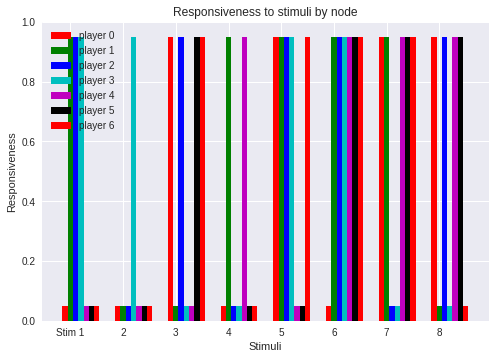

In [0]:
response = np.clip(response,.05,.95)
show_graph()


In [0]:
stimuli = 1
# print(response)
print(response[:,stimuli])
print(np.append(response[:1,stimuli],response[2:,stimuli]))

[0.05 0.95 0.95]
[0.05 0.95]
